In [1]:
# distances_villes_50k.py
# Génère une matrice de distances (km) entre toutes les communes françaises > 50 000 hab.

import math
import csv
import io
import sys
from urllib.request import urlopen, Request
import gzip

# --- CONFIG ---
# URL du CSV data.gouv (si l'URL change, remplacez par le lien CSV trouvé sur la page data.gouv)
DATA_GOUV_CSV_URL = "https://www.data.gouv.fr/api/1/datasets/r/f5df602b-3800-44d7-b2df-fa40a0350325" 
# (Si ce lien ne marche pas, téléchargez depuis la page: https://www.data.gouv.fr/fr/datasets/communes-et-villes-de-france-en-csv-excel-json-parquet-et-feather/)
POP_THRESHOLD = 50000
OUTPUT_COMMUNES = "py_data/villes_50k.csv"
OUTPUT_MATRIX = "py_data/distances_villes_50k.csv"

# --- Haversine ---
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088  # rayon moyen Terre en km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.asin(math.sqrt(a))

# --- Téléchargement du CSV ---
def download_csv(url):
    print("Téléchargement du fichier CSV depuis :", url)
    req = Request(url, headers={'User-Agent': 'python-urllib/3'})
    with urlopen(req, timeout=60) as resp:
        data = resp.read()
    # Certains fichiers sont fournis en gzip ; on essaie de décoder si nécessaire
    if data[:2] == b'\x1f\x8b':
        print("Fichier gz détecté — décompression")
        data = gzip.decompress(data)
    text = data.decode('utf-8', errors='replace')
    return text

# --- Lecture et filtre ---
def parse_communes(csv_text, pop_threshold=POP_THRESHOLD):
    reader = csv.DictReader(io.StringIO(csv_text))
    retenues = []
    for row in reader:
        try:
            pop = int(row.get("population","0") or 0)
        except:
            pop = 0
        if pop >= pop_threshold:
            # préférer lat/lon du centre si présent, sinon mairie
            lat = row.get("latitude_centre") or row.get("latitude_mairie") or ""
            lon = row.get("longitude_centre") or row.get("longitude_mairie") or ""
            try:
                latf = float(lat)
                lonf = float(lon)
            except:
                continue
            retenues.append({
                "code_insee": row.get("code_insee",""),
                "nom": row.get("nom_standard",""),
                "population": pop,
                "latitude": latf,
                "longitude": lonf
            })
    # tri par population décroissante (optionnel)
    retenues.sort(key=lambda x: x["population"], reverse=True)
    return retenues

# --- Écriture fichiers ---
def write_communes_csv(communes, filename=OUTPUT_COMMUNES):
    with open(filename, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["code_insee","nom","population","latitude","longitude"])
        for c in communes:
            w.writerow([c["code_insee"], c["nom"], c["population"], c["latitude"], c["longitude"]])
    print("Écrit:", filename)

def write_distance_matrix(communes, filename=OUTPUT_MATRIX):
    n = len(communes)
    codes = [c["code_insee"] for c in communes]
    with open(filename, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        # en-tête : vide + codes
        w.writerow([""] + codes)
        for i, a in enumerate(communes):
            row = [a["code_insee"]]
            for j, b in enumerate(communes):
                if i == j:
                    d = 0.0
                else:
                    d = haversine_km(a["latitude"], a["longitude"], b["latitude"], b["longitude"])
                row.append(f"{d:.3f}")
            w.writerow(row)
    print("Écrit matrice:", filename)

# --- Main ---
def main():
    try:
        csv_text = download_csv(DATA_GOUV_CSV_URL)
    except Exception as e:
        print("Erreur téléchargement :", e, file=sys.stderr)
        print("Si le téléchargement échoue, téléchargez manuellement le CSV depuis data.gouv et relancez en plaçant le fichier local 'communes.csv' dans le même dossier.")
        # fallback : tenter d'ouvrir un fichier local 'communes.csv'
        try:
            with open("communes.csv", "r", encoding="utf-8") as f:
                csv_text = f.read()
            print("Lu 'communes.csv' local.")
        except Exception as e2:
            print("Aucun CSV disponible. Fin.", file=sys.stderr)
            return

    communes = parse_communes(csv_text, POP_THRESHOLD)
    print("Communes retenues (>", POP_THRESHOLD, "):", len(communes))
    if len(communes) == 0:
        print("Aucune commune trouvée — vérifiez les noms de colonnes du CSV et la colonne 'population'.")
        return
    write_communes_csv(communes)
    write_distance_matrix(communes)

In [2]:
main()

Téléchargement du fichier CSV depuis : https://www.data.gouv.fr/api/1/datasets/r/f5df602b-3800-44d7-b2df-fa40a0350325
Communes retenues (> 50000 ): 130
Écrit: py_data/villes_50k.csv
Écrit matrice: py_data/distances_villes_50k.csv
Communes retenues (> 50000 ): 130
Écrit: py_data/villes_50k.csv
Écrit matrice: py_data/distances_villes_50k.csv


In [13]:
import csv

# Lire les villes depuis OUTPUT_COMMUNES
cities = []
cities_dict = {}  # Pour stocker les informations complètes si nécessaire

# Codes INSEE des villes d'outre-mer à exclure
codes_interdits = [
    "97411",  # Saint-Denis (Réunion)
    "97415",  # Saint-Paul (Réunion)
    "97416",  # Saint-Pierre (Réunion)
    "97409",  # Le Tampon (Réunion)
    "97422",  # Saint-Louis (Réunion)
    "97414",  # Saint-André (Réunion)
    "97209",  # Fort-de-France (Martinique)
    "97302",  # Cayenne (Guyane)
    "97311",  # Saint-Laurent-du-Maroni (Guyane)
    "97101",  # Les Abymes (Guadeloupe)
    "97611",  # Mamoudzou (Mayotte)
]

with open(OUTPUT_COMMUNES, 'r', encoding='utf-8') as f:
    reader = csv.DictReader(f)
    index = 0  # Compteur pour les villes retenues
    for row in reader:
        code_insee = row['code_insee']
        city_name = row['nom']
        
        if code_insee not in codes_interdits:
            cities.append(city_name)
            cities_dict[city_name] = {
                'index': index,
                'code_insee': code_insee,
                'population': int(row['population']),
                'latitude': float(row['latitude']),
                'longitude': float(row['longitude'])
            }
            index += 1

print(f"Nombre de villes: {len(cities)}")
print(f"Nombre de villes dans cities_dict: {len(cities_dict)}")
print(f"Villes uniques: {len(set(cities))}")
print(f"Premières villes: {cities[:10]}")

Nombre de villes: 119
Nombre de villes dans cities_dict: 119
Villes uniques: 119
Premières villes: ['Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice', 'Nantes', 'Montpellier', 'Strasbourg', 'Bordeaux', 'Lille']


In [14]:
# Lire la matrice de distances depuis OUTPUT_MATRIX
# On va créer un dictionnaire complet ville -> ville -> distance
distances_full = {}

with open(OUTPUT_MATRIX, 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    header = next(reader)  # Première ligne contient les codes INSEE
    codes_insee = header[1:]  # Ignore la première colonne vide
    
    # Créer un mapping code_insee -> nom de ville (pour toutes les villes)
    code_to_name = {}
    for name, info in cities_dict.items():
        code_to_name[info['code_insee']] = name
    
    for row in reader:
        code_insee_source = row[0]
        
        # Trouver le nom de la ville source
        city_name_source = code_to_name.get(code_insee_source)
        
        if city_name_source and city_name_source in cities_dict:
            distances_full[city_name_source] = {}
            
            # Pour chaque ville destination
            for i, code_insee_dest in enumerate(codes_insee):
                city_name_dest = code_to_name.get(code_insee_dest)
                if city_name_dest and city_name_dest in cities_dict:
                    distances_full[city_name_source][city_name_dest] = float(row[i + 1])

# Maintenant créer le format simplifié (liste de distances sans la diagonale)
distances = {}
for city in cities:
    distances[city] = [distances_full[city][other_city] 
                       for other_city in cities if other_city != city]

print(f"Nombre de villes dans le dictionnaire des distances: {len(distances)}")
print(f"Exemple - distances depuis {cities[0]}: {distances[cities[0]][:5]}...")
print(f"Longueur de la liste de distances pour {cities[0]}: {len(distances[cities[0]])}")

Nombre de villes dans le dictionnaire des distances: 119
Exemple - distances depuis Paris: [660.584, 391.556, 589.25, 683.972, 341.558]...
Longueur de la liste de distances pour Paris: 118


In [5]:
print(cities)

['Paris', 'Marseille', 'Lyon', 'Toulouse', 'Nice', 'Nantes', 'Montpellier', 'Strasbourg', 'Bordeaux', 'Lille', 'Rennes', 'Toulon', 'Reims', 'Saint-Étienne', 'Le Havre', 'Dijon', 'Grenoble', 'Angers', 'Villeurbanne', 'Saint-Denis', 'Nîmes', 'Aix-en-Provence', 'Clermont-Ferrand', 'Le Mans', 'Brest', 'Tours', 'Amiens', 'Annecy', 'Limoges', 'Metz', 'Boulogne-Billancourt', 'Perpignan', 'Besançon', 'Orléans', 'Rouen', 'Saint-Denis', 'Montreuil', 'Caen', 'Argenteuil', 'Mulhouse', 'Nancy', 'Tourcoing', 'Roubaix', 'Nanterre', 'Vitry-sur-Seine', 'Créteil', 'Avignon', 'Poitiers', 'Aubervilliers', 'Asnières-sur-Seine', 'Colombes', 'Dunkerque', 'Aulnay-sous-Bois', 'Versailles', 'Courbevoie', 'Béziers', 'La Rochelle', 'Rueil-Malmaison', 'Cherbourg-en-Cotentin', 'Champigny-sur-Marne', 'Pau', 'Mérignac', 'Saint-Maur-des-Fossés', 'Antibes', 'Ajaccio', 'Cannes', 'Saint-Nazaire', 'Drancy', 'Noisy-le-Grand', 'Issy-les-Moulineaux', 'Cergy', 'Levallois-Perret', 'Colmar', 'Calais', 'Pessac', 'Vénissieux', 'É

/home/vkretz/Programming/ai/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


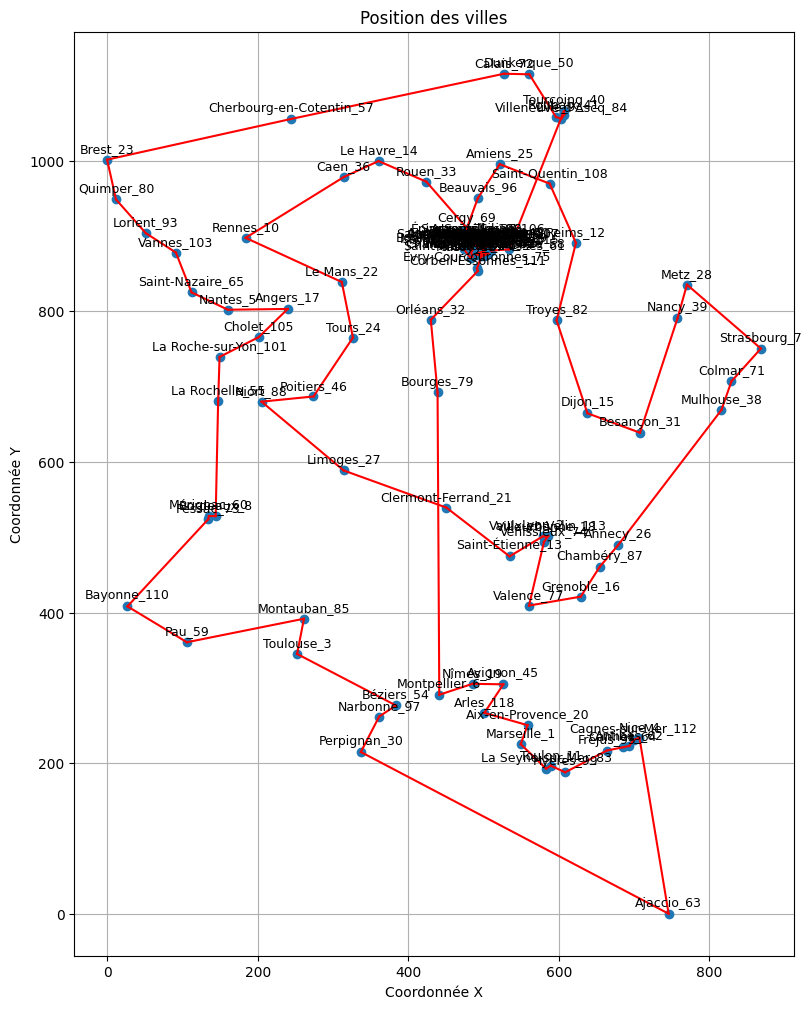

In [20]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# 1. Données fournies


# 2. Construction de la matrice de distance N x N
n_cities = len(cities)
distance_matrix = np.zeros((n_cities, n_cities))
for i, city in enumerate(cities):
    dist_list = distances[city].copy()
    dist_list.insert(i, 0)
    distance_matrix[i, :] = dist_list

# 3. Symétrisation de la matrice
symmetric_distance_matrix = (distance_matrix + distance_matrix.T) / 2

# 4. Application de l'algorithme MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress=False)
coords = mds.fit_transform(symmetric_distance_matrix)
coords_df = pd.DataFrame(coords, index=cities, columns=['x', 'y'])

# 5. Application de la rotation de 90° horaire
# x' = y et y' = -x
rotated_coords_df = pd.DataFrame(index=cities)
rotated_coords_df['x'] = -coords_df['y']
rotated_coords_df['y'] = coords_df['x']

# 6. Décalage des coordonnées pour les rendre positives
min_x = rotated_coords_df['x'].min()
min_y = rotated_coords_df['y'].min()
final_coords_df = pd.DataFrame(index=cities)
final_coords_df['x'] = rotated_coords_df['x'] - min_x
final_coords_df['y'] = rotated_coords_df['y'] - min_y

init_path = [0, 90, 51, 114, 104, 98, 40, 41, 84, 9, 50, 72, 57, 23, 80, 93, 103, 65, 5, 17, 105, 101, 55, 8, 60, 73, 110, 59, 85, 3, 54, 97, 30, 63, 4, 112, 62, 64, 95, 99, 11, 83, 1, 20, 118, 45, 19, 6, 79, 32, 111, 75, 44, 61, 58, 67, 92, 94, 43, 78, 115, 35, 109, 91, 66, 100, 86, 47, 34, 33, 14, 36, 10, 22, 24, 46, 88, 27, 21, 13, 2, 18, 113, 74, 77, 16, 87, 26, 38, 71, 7, 28, 39, 31, 15, 82, 12, 108, 25, 96, 69, 52, 117, 81, 102, 68, 29, 56, 42, 116, 37, 106, 48, 49, 53, 89, 70, 76, 107]
best_path = [0, 18, 22, 10, 6, 4, 21, 16, 1, 26, 3, 2, 25, 19, 14, 13, 17, 9, 23, 12, 7, 27, 8, 24, 15, 20, 11, 5]

# 7. Affichage des résultats
# print("Tableau des coordonnées finales :\n")
# with pd.option_context('display.max_rows', None, 
#                        'display.max_columns', None, 
#                        'display.width', 1000):
#     print(final_coords_df.round(2))

plt.figure(figsize=(10, 12))
plt.scatter(final_coords_df['x'], final_coords_df['y'], zorder=2)

for city, pos in final_coords_df.iterrows():
    plt.text(pos['x'], pos['y'] + 10, f"{city}_{cities.index(city)}", fontsize=9, ha='center', zorder=3)
# Tracer le chemin
path = init_path

for i in range(len(path)):
    start_city = final_coords_df.iloc[path[i]]
    end_city = final_coords_df.iloc[path[(i + 1) % len(path)]]
    plt.plot([start_city['x'], end_city['x']], [start_city['y'], end_city['y']], 'r-', zorder=2)

plt.title("Position des villes")
plt.xlabel("Coordonnée X")
plt.ylabel("Coordonnée Y")
plt.grid(True, zorder=1)
plt.gca().set_aspect('equal', adjustable='box')
# plt.show()
plt.savefig("france_cities.png")